In [3]:
import scipy.io as io
import scipy.ndimage as nd
import numpy as np

trial_img = io.loadmat("3DShapeNets/volumetric_data/chair/30/train/chair_000000184_2.mat")['instance']
trial_img = np.pad(trial_img,(2,2),'constant',constant_values=(0,0))
trial_img = nd.zoom(trial_img,(2,2,2),mode='constant',order=0)
#trial_img = np.pad(trial_img,(2,2),'constant',constant_values=(0,0))

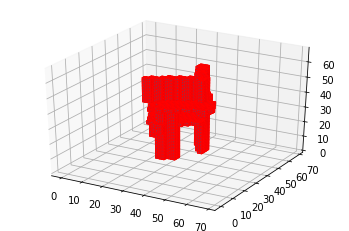

(68, 68, 68)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_aspect('equal')
ax.voxels(trial_img,edgecolor='red')
plt.show()
print(np.shape(trial_img))

In [5]:
import tensorflow.keras as tf
from tensorflow.keras.layers import Conv3D,BatchNormalization,Activation,Input,Conv3DTranspose
from tensorflow.keras.layers import LeakyReLU,Flatten,Dense
from tensorflow.keras import Model,Sequential
import os
#from tensorflow.keras.callbacks import Tensorboard
import time

In [ ]:
# Generator Network
# Creating a network with 6 layers.

def gen(gen_inp_shp,gen_fil,gen_ker,gen_stride,gen_activ,gen_num_layer):
    '''
    gen_inp_shp : Input shape of the generator network
    gen_fil : Filter list
    gen_ker : Kernel List
    gen_stride : Stride of the filters
    gen_activ : Acivation function list
    gen_num_layer : Number of generator layers
    '''
    #gen_num_layer = 6
    # first layer
    input_layer = Input(shape = gen_inp_shp)
    
    set1 = Conv3DTranspose(filters = gen_fil[0],kernel_size = gen_ker[0],strides = gen_stride[0])(input_layer)
    set1 = BatchNormalization()(set1,training=True)
    set2 = Activation(activation = gen_activ[0])(set1)
    
    for i in range(1,gen_num_layer):
        set2 = Conv3DTranspose(filters = gen_fil[i],kernel_size = gen_ker[i],strides = gen_stride[i])(set2)
        set2 = BatchNormalization()(set2,training=True)
        set2 = Activation(activation = gen_activ[i])(set2)
    
    gen_net = Model(inputs = input_layer,outputs = set2)
    print(gen_net.summary())
    return gen_net

def disc(disc_inp_shp,disc_fil,disc_ker,disc_stride,disc_activ,disc_num_layer):
    '''
    disc_inp_shp : Input shape of the discriminator network
    disc_fil : Filter list
    disc_ker : Kernel List
    disc_stride : Stride of the filters
    disc_activ : Acivation function list
    disc_num_layer : Number of discriminator layers
    '''
    input_layer = Input(shape = disc_inp_shp)
    
    set1 = Conv3D(filters = disc_fil[0],kernel_size = disc_ker[0],strides = disc_stride[0],padding='same')(input_layer)
    set1 = BatchNormalization()(set1,training=True)
    set2 = LeakyReLU(disc_activ[0])(set1)
    
    for i in range(1,disc_num_layer):
        set2 = Conv3D(filters = disc_fil[i],kernel_size = disc_ker[i],strides = disc_stride[i],padding='same')(set2)
        set2 = BatchNormalization()(set2,training=True)
        set2 = LeakyReLU(disc_activ[i])(set2)
    
    set2 = Flatten()(set2)
    set2 = Dense(32,activation='relu')(set2)
    set2 = Dense(1,activation = 'sigmoid')(set2)
    disc_net = Model(inputs = input_layer,outputs = set2)
    print(disc_net.summary())
    return disc_net

def load_img(path):
    #print(path)
    trial_img = io.loadmat(path)['instance']
    trial_img = np.pad(trial_img,(2,2),'constant',constant_values=(0,0))
    trial_img = nd.zoom(trial_img,(2,2,2),mode='constant',order=0)
    #trial_img = np.pad(trial_img,(2,2),'constant',constant_values=(0,0))
    return trial_img

def get_img_cat(DIR_PATH,train='True',ratio=1):
    print("Loading Data......")
    img_path = DIR_PATH+'/train/' if train else '/test/'
    imglist = [f for f in os.listdir(img_path) if f.endswith('.mat')]
    imglist = imglist[:int(len(imglist)*ratio)]
    data = np.asarray([load_img(img_path+f) for f in imglist],dtype=np.bool)
    print("Data loaded....")
    return data

def main():
    # generator network 6 layers
    alpha_size = 500
    gen_inp_shp = (1,1,1,alpha_size)
    gen_fil = [512,256,64,64,1]
    gen_ker = [4,4,4,4,2]
    gen_stride = [1,1,2,2,2]
    gen_activ = ['relu','relu','relu','relu','sigmoid']
    gen_num_layer = 5
    generator = gen(gen_inp_shp,gen_fil,gen_ker,gen_stride,gen_activ,gen_num_layer)
    
    # discriminator network 5 layers
    disc_inp_shp = [68,68,68,1]
    disc_fil = [64,128,256,512]
    disc_ker = [4,4,4,4]
    disc_stride = [2,2,2,1]
    disc_activ = [0.2,0.2,0.2,0.2]  #leaky relu slope
    disc_num_layer = 2
    disc_net = disc(disc_inp_shp,gen_fil,disc_ker,disc_stride,disc_activ,disc_num_layer)
    
    gen_lr = 1e-3
    dis_lr = 1e-5
    batch_size = 64
    DIR_PATH = '3DShapeNets/volumetric_data/chair/30'
    log_dir = 'logs'
    gen_volume_path = 'gen_vol'
    
    gen_opt = tf.optimizers.Adam(lr = gen_lr)
    dis_opt = tf.optimizers.Adam(lr = dis_lr)
    generator.compile(loss="binary_crossentropy",optimizer = gen_opt)
    disc_net.compile(loss="binary_crossentropy",optimizer = dis_opt)
    
    # seting up the gan network
    disc_net.trainable = False
    gan_model = Sequential()
    gan_model.add(generator)
    gan_model.add(disc_net)
    gan_opt = tf.optimizers.Adam(lr = 0.1)
    gan_model.compile(loss='binary_crossentropy',optimizer = gan_opt)
    
    #loading the dataset
    data = get_img_cat(DIR_PATH,True,0.8)
    data = np.expand_dims(data, axis=4)
    #print(np.shape(data))
    
    #adding tensorboard 
    #tensorboard = Tensorboard(log_dir="{}/{}".format(log_dir,time.time()))
    #tensorboard.set_model(generator)
    #tensorboard.set_model(disc_net)
    
    epochs = 10
    for epoch in range(epochs):
        print("Epochs:"+str(epoch))
        gen_loss = []
        dis_loss = []
        num_batch = int(np.shape(data)[0]/batch_size)
        print("Batches ===> "+str(num_batch))
        for i in range(num_batch):
            print("Batch:"+str(i+1))
            
            #create random noise and sample out real images
            z_sample = np.random.normal(0,0.4,size=[batch_size,1,1,1,alpha_size]).astype(np.float32)
            real_img = data[i*batch_size:(i+1)*batch_size,:,:,:]
            
            #make generator predict
            gen_img = generator.predict(z_sample,verbose=1)
            
            #making discriminator trainable
            disc_net.trainable = True
            
            #generate labels
            label_real = np.array([1]*batch_size)
            label_fake = np.array([0]*batch_size)
            
            #train the dicriminator network
            print("===== Discriminator Training ======")
            disc_loss = disc_net.fit(np.concatenate((real_img,gen_img),axis=0),np.concatenate((label_real,label_fake),axis=0),epochs=1,verbose=1)
            disc_net.trainable = False
            
            #train adverserial network
            print("===== Adverserial Training =======")
            z_sample = np.random.normal(0,0.4,size=[batch_size,1,1,1,alpha_size]).astype(np.float32)
            gan_loss = gan_model.fit(z_sample,np.array([1]*batch_size),epochs=1,verbose=1)
            
            dis_loss.append(disc_loss.history['loss'])
            gen_loss.append(gan_loss.history['loss'])
            
        '''
        if i%10==0:
            z_sample = np.random.normal(0,0.4,size=[batch_size,1,1,1,alpha_size]).astype(np.float32)
            gen_img = generator.predict(z_sample,verbose=1)
            for i,gen in enumerate():
                voxels = np.squeeze()
        '''
main()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 1, 500)]    0         
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 4, 4, 4, 512)      16384512  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 4, 512)      2048      
_________________________________________________________________
activation (Activation)      (None, 4, 4, 4, 512)      0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 7, 7, 7, 256)      8388864   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 7, 256)      1024      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 7, 256)      0     

In [5]:
%load_ext tensorboard